# Rabi example using Evolver

## Pulsed ESR and Rabi oscillation examples

### Summary

This script contains the same examples as the previously posted "Rabi Pulsehandler Tutorial" but now using the _new_ base scripts. The scripts handle the "creation" of the NV system, different types of pulses, the static Hamiltonian, and execution of pulses, among many others.

In the pulsed ESR example, we will do a frequency sweep to find the resonances for our NV system, but also vary the Rabi frequency to illustrate how the system responds to stronger driving fields.

After finding a resonance frequency using our ESR example, we will simulate electronic spin-population oscillations under a microwave drive. We'll also see how the amplitude and frequency of the oscillations change with different detunings. 

### Import packages

In [1]:
from qutip import *
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as scs

from multiprocess import Pool
import time

import sys
import os

In [2]:
from tempo.qsys import Qsys
from tempo.hamiltonian import Hamiltonian
from tempo.pulse_recipe import Pulse_recipe
from tempo.evolver import Evolver
from tempo.pulse_sequence import Pulse_sequence
from tempo.pulse import Pulse

In [3]:
# import new base scripts
# from qsys import *
# from ham import *
# from pulsetype import *
# from hamfuncs import *
# from evolver import *
# from pulsesequence import *
# from pulse import *

## Pulsed ESR sim

### Define NV system

The Qsys constructor takes a tuple of the dimensions of each particle's Hilbert space. In this case the tuple has two entries because we have two particles, with the electron having spin-1 and the nucleus having spin-1/2. 

In [4]:
# initialize the NV system: (3, 2) for the dimensions of the electron's and nucleus' Hilbert spaces
# creates a coupled system of the two spins
qs = Qsys((3,2))

### Define system's initial state for solver

For this simulation, we will use ms = 0, mi = +1/2.

In [5]:
# define initial state: 
state_init = tensor(basis(3,1), basis(2, 0)) # ms = 0 (electron), mi = +1/2 state (nucleus)
state_init

Quantum object: dims = [[3, 2], [1, 1]], shape = (6, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

In [6]:
# state_init = 0.5*tensor(basis(3,1)*basis(3,1).dag(), basis(2,0)*basis(2,0).dag())
# state_init

### Applied B-field (static)

In [7]:
#
# Define applied magnetic field
#
Bx = 0; By = 0; Bz = 100 # B field components (G)
B0_init = np.array([Bx, By, Bz]) # B field vector (G)

# If desired, rotate magnetic field around y-axis, by angle theta
theta = 0 #degrees
theta *= np.pi/180
Ry = np.array([[np.cos(theta), 0, np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]]) # rotation opr
B0 = np.dot(Ry, B0_init) 
print(B0)

[  0.   0. 100.]


### Define array of microwave frequencies to loop through

In [8]:
frq_start = 3140 #MHz
frq_end = 3160 #MHz
nsteps_frq = 81 #number of steps between frq_start and frq_end
arr_frqs = np.linspace(frq_start, frq_end, nsteps_frq)

### Define Rabi frequency

Do a frequency sweep for 3 different Rabi frequencies: 1, 2, and 5 MHz. 

We will apply a microwave drive of the form

\begin{equation}
\frac{\hat{H}(t)}{\hbar} = 2\pi\cdot \underbrace{\cos{(\omega t)}}_\text{time-dependent coefficient} \cdot \sqrt{2}\Omega \hat{S}_x
\end{equation}

where $ \Omega $ is the Rabi frequency and $ \omega $ is the driving frequency. $\Omega $ describes the strength of the driving field via a general formula $ \Omega = -\gamma B $. $ S_x $ is the electron spin operator 

\begin{equation}
\hat{S}_x = \frac{1}{\sqrt{2}} \cdot \left[\begin{matrix}0 & 1 & 0\\1 & 0 & 1\\0 & 1 & 0\end{matrix}\right] \otimes \mathbb{1}
\end{equation}

The MW drive will be applied for the duration of one $ \pi$-pulse, 
$$ t_{\pi} = \frac{1}{2\Omega} $$.


In [9]:
# Define Rabi frequency

gammaNV = -2.8025

#
# Omega_rabi represents the on-resonance Rabi frequency in MHz
# Change Omega_rabi as needed (larger Rabi -> faster pulse sequences, but linewidth suffers/increases)
#
Omega_rabi = [1, 2, 5] # Rabi freq in MHz: describes strength of microwave drive field. 
B_amplitude = [omega / gammaNV for omega in Omega_rabi]

# Define duration of pi pulse from Rabi frequency
time_pi = [1 / omega /2 for omega in Omega_rabi] #seconds
print(time_pi)

[0.5, 0.25, 0.1]


### Set up static Hamiltonian

Set up a static Hamiltonian with hyperfine interaction for the system (from QuTiP tutorial): 

$$
\frac{\hat{H}}{h} =  \underbrace{D \hat{S}_z^2}_\text{Zero-field splitting} + \underbrace{\gamma_e \vec{B}\cdot \vec{S}}_\text{Electron Zeeman interaction} + \underbrace{\gamma_n \vec{B}\cdot \vec{I}}_\text{Nuclear Zeeman interaction} + \underbrace{\vec{S} \cdot \overline{A} \cdot \vec{I}}_\text{Hyperfine interaction} + \underbrace{\Big(Q \hat{I}_z^2\Big)}_\text{Quadrupole Splitting (N14)} + \underbrace{\cos{(\omega t)} \cdot \sqrt{2}\Omega \hat{S}_x}_\text{Microwave drive}
$$

Above, the first 5 terms are static and the last is the time-dependent term or the "pulse." $\vec{S}$ and $\vec{I}$ contain the spin operators for the electron and nuclear spin respectively. 

$\vec{B}$ is the magnetic field vector relative to an NV$^-$ axis oriented in the z-direction.

$$\vec{S} = \begin{pmatrix} \hat{S}_x \\ \hat{S}_y \\\hat{S}_z\end{pmatrix}, \vec{I} = \begin{pmatrix} \hat{I}_x \\ \hat{I}_y \\\hat{I}_z\end{pmatrix}, \vec{B} = \begin{pmatrix} B_x \\ B_y \\ B_z\end{pmatrix}, \overline{A} = \begin{bmatrix} A_\perp & 0 & 0\\ 0 & A_\perp & 0 \\ 0 & 0 & A_{||}\end{bmatrix}$$

In [10]:
# helper for Hamiltonian terms
def dotproduct(vecV, vecU):
    #
    # Dot product between vector V = (Vx,Vy,Vz) and vector U = (Ux,Uy,Uz)
    #
    return sum([Vcomp*Ucomp for Vcomp, Ucomp in zip(vecV, vecU)])

In [11]:
# Define the static Hamiltonian terms involved in frequency sweep
# nucleus is N15 

# Define functions for each Hamiltonian term
# Args must be "matrices" and "parameters" in that order
def ZFSfunc(Hmats, Hpars):
    return Hpars['coeff']*Hpars['ZFSconst']*Hmats['Sz']*Hmats['Sz']

# Define dictionaries of scalars and operators
ZFSpars = {'coeff': 2*np.pi, 'ZFSconst': 2.87e3}
ZFSmats = {'Sz': qs.Sz[0]}

In [12]:
def ZeeNVfunc(Hmats, Hpars):
    return Hpars['coeff']*Hpars['gammaNV']*tensor(dotproduct(Hpars['Bfield'], Hmats['S1']), identity(Hpars['P2dims']))

ZeeNVpars = {'coeff': -2*np.pi, 'Bfield': B0, 'gammaNV': -2.8025, 'P2dims': qs.dimensions[1]}
ZeeNVmats = {'S1': jmat(qs.stot[0])}

In [13]:
def ZeeNucfunc(Hmats, Hpars):
    return Hpars['coeff']*Hpars['gammaNuc']*tensor(identity(Hpars['P1dims']), dotproduct(Hpars['Bfield'], Hmats['S2']))

ZeeNucpars = {'coeff': -2*np.pi, 'Bfield': B0, 'gammaNuc': -431.6e-6, 'P1dims': qs.dimensions[0]}
ZeeNucmats = {'S2': jmat(qs.stot[1])}

In [14]:
def HFfunc(Hmats, Hpars):
    return Hpars['coeff']*(Hmats['A'][2,2] * Hmats['Sz'] * Hmats['Iz'] + Hmats['A'][0,0] * (Hmats['Sx']*Hmats['Ix'] + Hmats['Sy']*Hmats['Iy']))

A_N15 = np.array([[3.65,0,0],[0,3.65,0],[0,0,3.03]]) # Nitrogen-15 HF tensor

HFpars = {'coeff': 2*np.pi}
HFmats = {'A': A_N15, 'Sz': qs.Sz[0], 'Iz': qs.Sz[1], 
          'Sx': qs.Sx[0], 'Ix': qs.Sx[1], 'Sy': qs.Sy[0], 'Iy': qs.Sy[1]}

In [15]:
# create Hamiltonian objects to store these terms
HZFS = Hamiltonian(ZFSmats, ZFSpars, ZFSfunc)
HZeeNV = Hamiltonian(ZeeNVmats, ZeeNVpars, ZeeNVfunc)
HZeeNuc = Hamiltonian(ZeeNucmats, ZeeNucpars, ZeeNucfunc)
HHF = Hamiltonian(HFmats, HFpars, HFfunc)

In [16]:
# get the total static Hamiltonian operator
Hstat = HZFS.H + HZeeNV.H + HZeeNuc.H + HHF.H

In [17]:
Hstat

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 1.98032591e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.97839499e+04  1.62165227e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.62165227e+01  1.35591139e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.35591139e-01
   1.62165227e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.62165227e+01
   1.62624957e+04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.62812626e+04]]

### Define AC drive Hamiltonian

The time-dependent Hamiltonian term is encoded in a "pulse type." This will then be used to create a pulse with the correct parameters.

In [18]:
# define the time-dependent pulse type
# in this case AC drive, A*cos(omega*(t+offset)+phase)
# function must have inputs t, args
def ACD(t, args):
    return args['B_amp']*np.cos(2*np.pi*args['freq']*(t + args['offset']) + args['phase'])

H_Bac = 2 * np.pi * gammaNV * qs.Sx[0] * np.sqrt(2)
ACDkeys = ['B_amp', 'freq', 'offset', 'phase']

In [19]:
# create the pulsetype object with the operator, parameter names, and function
# we are not inputting numerical parameters yet; this pulsetype is a blueprint for any ACD pulse
# values will come in later

# The first input should be a Hamiltonian object, but you can pass in only an operator 
# into Hamiltonian() if your operator is simple (doesn't require multiplying different standalone operators, etc)
ACDpulsetype = Pulse_recipe(Hamiltonian(H_Bac), ACDkeys, ACD)

### Loop through microwave frequencies, append each pulse sequence object to list for execution

Loop through both the 3 different Rabi frequencies and the range of driving frequencies by applying a $\pi$-pulse to the initial state ms = 0, mi = +1/2 each time. 

In [20]:
# create a list of pulse sequences, each one handling a different frequency in the sweep
ls_pulsehandlers_Rabi = [] 
tlists = []
    
for i in np.arange(len(Omega_rabi)):
    for frq in arr_frqs:
        
        duration = time_pi[i]
        starttime = 0

        # pulse sequence object
        pulse_handler_Rabi = Pulse_sequence(Hstat = Hstat)
        tlists.append(np.linspace(starttime, duration, 100))

        B_amp = B_amplitude[i]
        frequency = frq
        offset = 0
        phase = 0

        # create a pulse with the ACD pulsetype, and input numerical values 
        # add to the list of pulses in pulse sequence
        pulse_rabi = Pulse(ACDpulsetype, start_time = starttime, duration = duration, coeff_params = {'B_amp': B_amp, 'freq': frq, 'offset': offset, 'phase': phase})
        pulse_handler_Rabi.add_pulse(pulse_rabi)

        ls_pulsehandlers_Rabi.append(pulse_handler_Rabi)

### Define function for executing pulse sequences

In [21]:
# define how to execute pulse
# this creates an Evolver object and then calls its evolve() function, which returns the state of the system at the timestamps specified in tlist
def exec_pulse_Rabi(state_init, tlist, pulsehandler):
    opts = Options(rhs_reuse = False, nsteps = 1000000, atol=1e-9, rtol=1e-9, tidy=False)
    return Evolver(state_init, tlist, pulsehandler, opts = opts).evolve(method = 'regular')

### Execute pulse sequences in parallel

In [22]:
# execute pulse sequences in parallel
sim_starttime = time.time()

n = len(ls_pulsehandlers_Rabi)

# inputs are initial state, tlist, and pulse sequence, as outlined in the args for exec_pulse_Rabi
inputs = zip([state_init]*n, tlists, ls_pulsehandlers_Rabi)

if __name__ == '__main__':
    with Pool(processes = n) as pool:
        output_map = pool.starmap(exec_pulse_Rabi, inputs)
        pool.close()
        pool.join()

output_map = list(output_map)

sim_endtime = time.time()
print('Time taken (s)', round(sim_endtime- sim_starttime,3))

Time taken (s) 197.71


### Separate the 3 different sweeps into their own arrays

In [23]:
# the only purpose of the code in this cell is to separate the output of the parallel map into the 
# three sets of Rabi frequencies. Again, the first 81 entries in output_map are for Rabi = 1 MHz, etc. 

n_rabi_frqs = len(Omega_rabi) # number of separate frequency sweeps, one for each Rabi frequency
len_frqsweep = int(len(output_map)/n_rabi_frqs) # length of one frequency-sweep array's results
#print(len_frqsweep)

ls_states_frqsweep = [[]]*n_rabi_frqs # create a 2D array to store each of the sweeps' results

for i in np.arange(n_rabi_frqs):
    ls_states_frqsweep[i] = [elem.states[-1] for elem in output_map[i*len_frqsweep:(i+1)*len_frqsweep]] 
    # By taking the very last element of each pulse, we get the state of the system at the end of 
    # each pulse

In [24]:
#population operator whose expectation value we are getting
exp_op = qs.basisstates(0)[1]
exp_op

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

### Plot ms = 0 population vs frequency of drive

Resonance frequency: [3151.75]


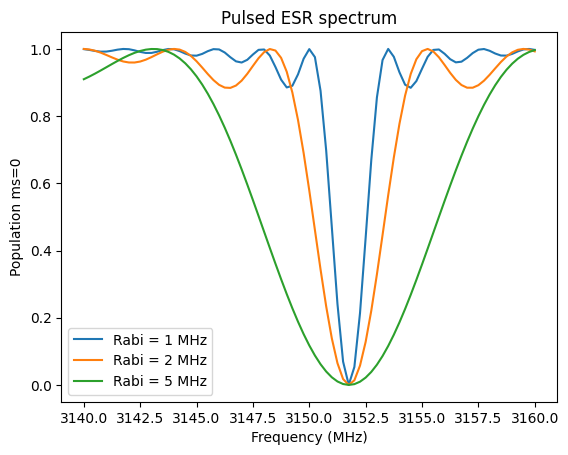

In [25]:
popdata = [[]]*n_rabi_frqs
for i in np.arange(n_rabi_frqs):
    popdata[i] = expect(exp_op, ls_states_frqsweep[i])
    plt.plot(arr_frqs, popdata[i], '-')

resonance = arr_frqs[scs.find_peaks(1-popdata[2], height = 0.2)[0]]
print('Resonance frequency:', resonance)

plt.title('Pulsed ESR spectrum')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Population ms=0')
plt.legend(['Rabi = 1 MHz', 'Rabi = 2 MHz', 'Rabi = 5 MHz'])
plt.show()

## Rabi oscillation sim

Now, driving the system at the resonance frequency and varying the detuning, we can see how the amplitude and frequency of the oscillation change. During the MW drive, the spin population will oscillate between two extremes; at resonance and no detuning, it will oscillate at the generalized Rabi frequency, $ W = \Omega $, between the ms = 0 and the ms = +1 state. When detuning $\Delta$ is added, it will oscillate at a frequency

$$ W = \sqrt{\Delta^2+\Omega^2} $$

where $ W $ is again the generalized Rabi frequency, $ \Delta = \omega - \omega_0 $ is the detuning, and $ \Omega $ is the Rabi frequency. $ \omega $ is the driving frequency and $ \omega_0 $ is the resonance frequency for the transition we are probing. 

The population curve will again follow the equation

\begin{equation}
    P_0(t) = 1-(\frac{\Omega}{W})^2\sin^2(2\pi\times\frac{Wt}{2})
\end{equation}

but this time the independent variable is $t$ because we are measuring the state of the system over time.

From above, we see that the amplitude of the population oscillation is determined by the ratio $ (\frac{\Omega}{W})^2 $.

### Array of times for measuring state during continuous MW drive

In [26]:
# Array of times for measuring state during continuous MW drive
tfp_max = 7 # us
arr_timesfp = np.linspace(0, tfp_max, 100)
# print('arr_timesfp', arr_timesfp, '\n')

### AC drive detuning from resonance (MHz)

In [27]:
# define an array of detunings to loop through
detuns = [0, 1, 2]

### Loop through detunings, append to pulse sequence

In [28]:

ls_pulsehandlers_Rabi = []

# use B-field strength of 1MHz/-2.8025
B_amp = B_amplitude[0]

for dt in detuns:
    
    duration_2 = tfp_max
    starttime_2 = 0
    offset = 0
    phase = 0
    
    # pulse sequence object:
    pulse_handler_Rabi = Pulse_sequence(Hstat = Hstat)
    
    frq = resonance+dt
    
    # create a pulse, still with the ACD pulsetype, and input numerical values 
    # add to the list of pulses in pulse sequence
    pulse_rabi = Pulse(ACDpulsetype, start_time = starttime_2, duration = duration_2, coeff_params = {'B_amp': B_amp, 'freq': frq, 'offset': offset, 'phase': phase})
    pulse_handler_Rabi.add_pulse(pulse_rabi)

    ls_pulsehandlers_Rabi.append(pulse_handler_Rabi)

### Execute all three sequences in parallel

In [29]:
# execute pulse sequences in parallel
sim_starttime = time.time()

n = len(ls_pulsehandlers_Rabi)

# inputs are initial state, tlist, and pulse sequence, as outlined in the args for exec_pulse_Rabi
inputs = zip([state_init]*n, [arr_timesfp]*n, ls_pulsehandlers_Rabi)

if __name__ == '__main__':
    with Pool(processes = n) as pool:
        output_map = pool.starmap(exec_pulse_Rabi, inputs)
        pool.close()
        pool.join()

output_map = list(output_map)

# if you are on Mac, and want to see a progress bar, you can uncomment below
# output_map = parallel_map(exec_pulse_Rabi, np.arange(len(ls_pulsehandlers_Rabi)), 
#                             task_args=(state_init, arr_timesfp, ls_pulsehandlers_Rabi), progress_bar=True)

sim_endtime = time.time()
print('Time taken (s)', round(sim_endtime- sim_starttime,3))

python(14001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Time taken (s) 21.308


### Put the results of each sequence in a separate array

In [30]:
ls_states_detunings = [[]]*len(output_map)

for i in np.arange(len(output_map)):
    ls_states_detunings[i] = output_map[i].states

In [31]:
exp_op

Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]

### Plot population in the initial state (ms = 0) vs. pulse duration

We expect the frequencies of the plots to be as follows:
- Detuning = 0 --> $ W = \Omega = 1 $ MHz
- Detuning = 1 MHz --> $ W = \sqrt{\Delta^2+\Omega^2} = \sqrt{2} $ MHz
- Detuning = 2 MHz --> $ W = \sqrt{\Delta^2+\Omega^2} = \sqrt{5} $ MHz

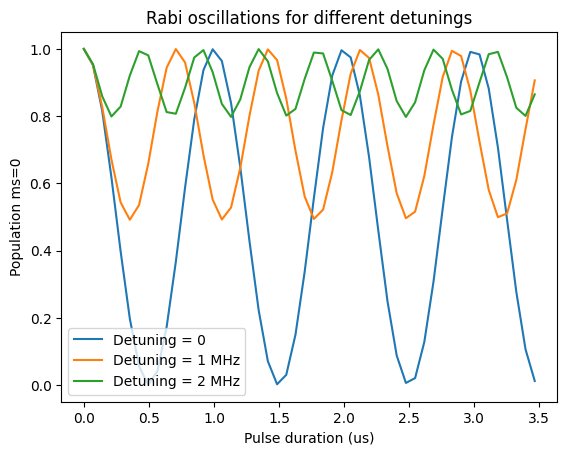

In [32]:
popdata = [[]]*len(output_map)
for i in np.arange(len(output_map)):
    popdata[i] = expect(exp_op, ls_states_detunings[i])

# plot for half of the time range just to make plot less cluttered
for i in np.arange(len(output_map)):
    plt.plot(arr_timesfp[0:50], popdata[i][0:50], '-')

# plt.plot(arr_timesfp, popdata[2], '-')


plt.title('Rabi oscillations for different detunings')
plt.xlabel('Pulse duration (us)')
plt.ylabel('Population ms=0')
plt.legend(['Detuning = 0', 'Detuning = 1 MHz', 'Detuning = 2 MHz'])
plt.show()

### Calculate frequency of each curve using FFT

In [33]:
def get_fft(t, data, cutoff_frq=0.1):
    power_spect = np.abs(np.fft.fft(data))**2
    freq = np.fft.fftfreq(data.size, d=t[1]-t[0])
    freqstep = freq[1]- freq[0]
    
    bools_frq = freq > cutoff_frq
    freq = freq[bools_frq]
    power_spect = power_spect[bools_frq]
    
    return freq, power_spect

Peaks located at (MHz):
[0.99       1.41428571 2.26285714]


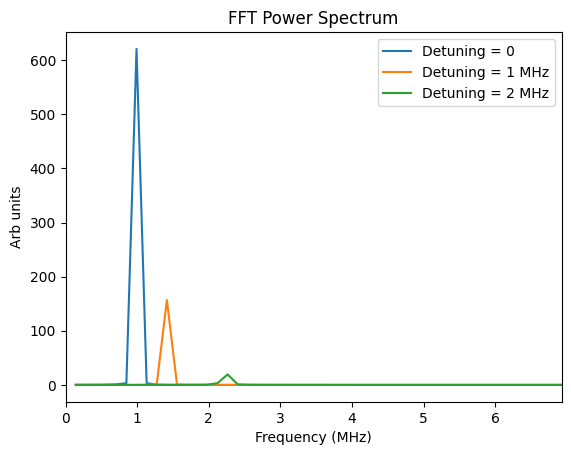

In [34]:
# Evaluate Fourier Transform

peaks = np.zeros(3)

print("Peaks located at (MHz):")

for i in np.arange(len(popdata)):
    xfrq, yps = get_fft(arr_timesfp, popdata[i], cutoff_frq=0.1)
    idx_peak = scipy.signal.find_peaks(np.array(yps), height=np.median(popdata[i]))[0]
    peaks[i] = xfrq[idx_peak]
    plt.plot(xfrq, yps)

print(peaks)
plt.xlim([0,max(xfrq)])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Arb units')
plt.title('FFT Power Spectrum')
plt.legend(['Detuning = 0', 'Detuning = 1 MHz', 'Detuning = 2 MHz'])
plt.xticks(np.arange(7))
plt.show()